In [1]:
import pandas as pd 
import spacy

In [3]:
phab_path = "/mmfs1/gscratch/comdata/users/mjilg/mw-repo-lifecycles/case1/0312_resolved_ve_phab_comments.csv"
phab_df = pd.read_csv(phab_path)

In [4]:
#find gerrit phab PHID: PHID-USER-idceizaw6elwiwm5xshb
phab_df['isGerrit'] = phab_df['AuthorPHID'] == 'PHID-USER-idceizaw6elwiwm5xshb'
#cleaning df
phab_df['id'] = phab_df.index + 1
#may have to build out the reply_to column 
phab_df['reply_to'] = phab_df.groupby('TaskPHID')['id'].shift()
phab_df['reply_to'] = phab_df['reply_to'].where(pd.notnull(phab_df['reply_to']), None)

phab_df = phab_df.rename(columns={
    'AuthorPHID': 'speaker',
    'TaskPHID': 'conversation_id',
    'WMFaffil':'meta.affil',
    'isGerrit': 'meta.gerrit'
})

#  before 9-30-2013 after 11-11-2012
phab_df['timestamp'] = pd.to_datetime(phab_df['date_created'], unit='s', origin='unix', utc=True)
filtered_phab_df = phab_df[(phab_df['date_created'] < 1380585599) & (phab_df['date_created'] > 1352592000)]

#removing headless conversations
task_phab_df = filtered_phab_df[filtered_phab_df['comment_type']=="task_description"]
headed_task_phids = task_phab_df['conversation_id'].unique()
filtered_phab_df = filtered_phab_df[filtered_phab_df['conversation_id'].isin(headed_task_phids)]

#removing gerrit comments 
comment_phab_df = filtered_phab_df[filtered_phab_df['meta.gerrit'] != True]

In [5]:
unique_conversation_ids = len(comment_phab_df['conversation_id'].unique())
unique_ids = len(comment_phab_df['id'].unique())
unique_speakers = len(comment_phab_df['speaker'].unique())

print(f"Unique conversation_ids: {unique_conversation_ids}")
print(f"Unique ids: {unique_ids}")
print(f"Unique speakers: {unique_speakers}")

Unique conversation_ids: 1937
Unique ids: 7987
Unique speakers: 217


In [6]:
import re

def preprocess_text(text):
    text = str(text)
    text = text.replace('*', ' ')
    text = text.replace('-', ' ')
    text = re.sub(r'http\S+', '', text)
    return text

In [7]:
comment_phab_df['processed_text'] = comment_phab_df['text'].apply(preprocess_text)

/tmp/ipykernel_43056/3649688126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['processed_text'] = comment_phab_df['text'].apply(preprocess_text)


In [8]:
comment_phab_df['processed_resolved_text'] = comment_phab_df['resolved_text'].apply(preprocess_text)

/tmp/ipykernel_43056/1316816771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['processed_resolved_text'] = comment_phab_df['resolved_text'].apply(preprocess_text)


In [9]:
nlp = spacy.load("en_core_web_sm")

def extract_dependency_tree(text):
    doc = nlp(text)
    dependency_trees = []
    
    for sentence in doc.sents:
        for token in sentence:
            token_info = (
                token.text, 
                token.lemma_, 
                token.dep_, 
                token.head.text, 
                list(token.ancestors), 
                list(token.subtree), 
                list(token.children)
            )
            dependency_trees.append(token_info)
        
    return dependency_trees

In [10]:
comment_phab_df['dependency_tree'] = comment_phab_df['processed_text'].apply(extract_dependency_tree)

/tmp/ipykernel_43056/2805711855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['dependency_tree'] = comment_phab_df['processed_text'].apply(extract_dependency_tree)


In [11]:
comment_phab_df['resolved_dependency_tree'] = comment_phab_df['processed_resolved_text'].apply(extract_dependency_tree)

/tmp/ipykernel_43056/2117289791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['resolved_dependency_tree'] = comment_phab_df['processed_resolved_text'].apply(extract_dependency_tree)


In [12]:
#get VAD scores
import numpy as np
#https://saifmohammad.com/WebPages/nrc-vad.html
column_headings = ['Word', 'Valence', 'Arousal', 'Domination']
vad_lexicon = pd.read_csv('NRC-VAD-Lexicon.txt', delimiter='\t', header=None, names=column_headings)
vad_dict = vad_lexicon.set_index('Word').T.to_dict()

def vad_scoring(dependency_tree):
    valence = []
    arousal = []
    dominance = []
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            valence.append(vad_dict[lemma]['Valence'])
            arousal.append(vad_dict[lemma]['Arousal'])
            dominance.append(vad_dict[lemma]['Domination'])

    # Compute average scores across the comment
    avg_valence = np.mean(valence) if valence else 0
    avg_arousal = np.mean(arousal) if arousal else 0
    avg_dominance = np.mean(dominance) if dominance else 0

    return [avg_valence, avg_arousal, avg_dominance]

def dominance_prevail(dependency_tree):
    dominant_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Domination'] >= 0.75:
                dominant_words += 1
            if vad_dict[lemma]['Domination'] <= 0.25:
                dominant_words += 1
    return dominant_words

def arousal_prevail(dependency_tree):
    arousal_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Arousal'] >= 0.75:
                arousal_words += 1
            if vad_dict[lemma]['Arousal'] <= 0.25:
                arousal_words += 1
    return arousal_words

def valence_prevail(dependency_tree):
    valence_words = 0 
    for token, lemma, dep, head, ancestors, subtree, children in dependency_tree:
        if lemma in vad_dict:
            if vad_dict[lemma]['Valence'] >= 0.75:
                valence_words += 1
            if vad_dict[lemma]['Valence'] <= 0.25:
                valence_words += 1
    return valence_words
    

In [13]:
#establishing per-comment VAD scores 
comment_phab_df['avg_vad_scores'] = comment_phab_df['dependency_tree'].apply(vad_scoring)
comment_phab_df['dominant_wc'] = comment_phab_df['dependency_tree'].apply(dominance_prevail)
comment_phab_df['arousal_wc'] = comment_phab_df['dependency_tree'].apply(arousal_prevail)
comment_phab_df['valence_wc'] = comment_phab_df['dependency_tree'].apply(valence_prevail)

/tmp/ipykernel_43056/2858732056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['avg_vad_scores'] = comment_phab_df['dependency_tree'].apply(vad_scoring)
/tmp/ipykernel_43056/2858732056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df['dominant_wc'] = comment_phab_df['dependency_tree'].apply(dominance_prevail)
/tmp/ipykernel_43056/2858732056.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [14]:
comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
comment_phab_df = comment_phab_df.drop(columns=['avg_vad_scores'])

/tmp/ipykernel_43056/335308388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
/tmp/ipykernel_43056/335308388.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_phab_df[['average_v_score', 'average_a_score', 'average_d_score']] = pd.DataFrame(comment_phab_df['avg_vad_scores'].tolist(), index=comment_phab_df.index)
/tmp/ipykernel_43056

In [15]:
# expand the dependency parser 

#pattern = r'\b(ve|VE|visualeditor|VisualEditor)\b'
#pattern = r'\b(WMF|Foundation)\b'
#pattern = r'\b(bots|scripts|gadgets)\b'

dependency_relations = []
resolved_dependency_relations = []

for index, row in comment_phab_df.iterrows():
    text = row['text']
    timestamp = row['timestamp']
    comment_id = row['id']
    conversation_id = row['conversation_id']
    WMFaffil = row['meta.affil']
    
    for token, lemma, dep, head, ancestors, subtree, children in row['dependency_tree']:
        dependency_relations.append({
            'comment_id': comment_id,
            'timestamp': timestamp,
            'wmfAffil':WMFaffil,
            'token': token,
            'dependency': dep,
            'head': head,
            'depth': len(list(ancestors)), 
            'children': len(list(children)) 
        })
    for token, lemma, dep, head, ancestors, subtree, children in row['resolved_dependency_tree']:
        resolved_dependency_relations.append({
            'comment_id': comment_id,
            'timestamp': timestamp,
            'wmfAffil':WMFaffil,
            'token': token,
            'dependency': dep,
            'head': head,
            'depth': len(list(ancestors)), 
            'children': len(list(children)) 
        })

resolved_dependency_relations_df = pd.DataFrame(resolved_dependency_relations)            
dependency_relations_df = pd.DataFrame(dependency_relations)

In [16]:
#now analysis/plotting 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [23]:
given_date = pd.Timestamp("2013-07-01").tz_localize(None)
task_phab_df['timestamp'] = pd.to_datetime(task_phab_df['timestamp'], unit='s').dt.tz_localize(None)
task_phab_df = task_phab_df[(task_phab_df['date_created'] < 1380585599) & (task_phab_df['date_created'] > 1352592000)]
task_phab_df['week_bin'] = ((task_phab_df['timestamp'] - given_date).dt.days // 7)

In [26]:
task_phab_df
task_phab_df.to_csv("/mmfs1/gscratch/comdata/users/mjilg/mw-repo-lifecycles/case1/phab_tasks.csv", index=False)

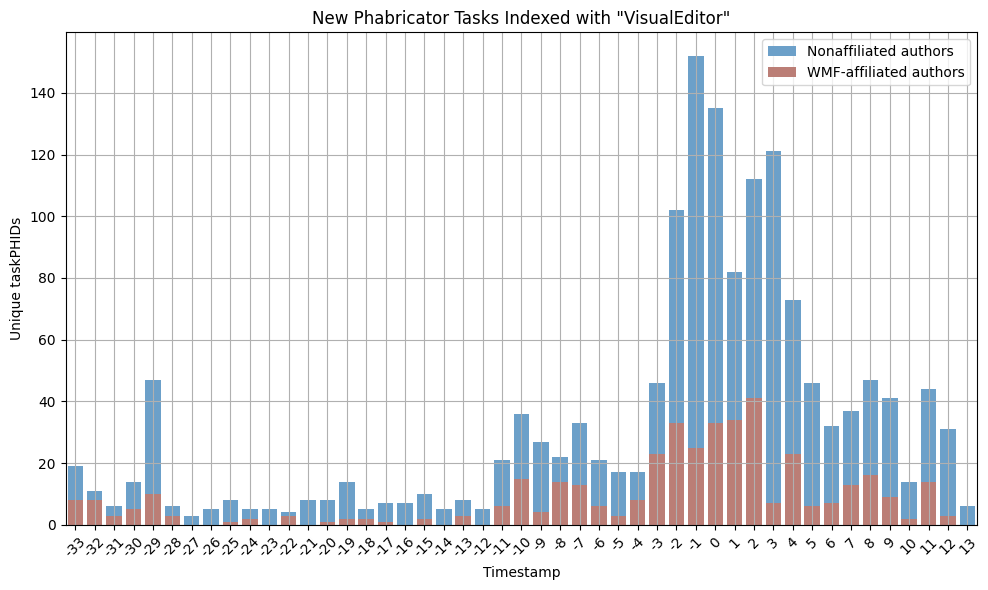

In [25]:
plt.figure(figsize=(10, 6))
#task_phab_df = phab_df[phab_df['comment_type']=="task_description"]
task_phab_df['first_comment'] = task_phab_df.groupby('speaker')['timestamp'].rank(method='first') <= 5
#task_phab_df = task_phab_df[(task_phab_df['date_created'] < 1380585599) & (task_phab_df['date_created'] > 1352592000)]

#task_phab_df['week'] = task_phab_df['timestamp'].dt.to_period('W').dt.start_time
#unique_taskPHIDs = task_phab_df.groupby('week')['conversation_id'].nunique()

wmf_task_phab_df = task_phab_df[(task_phab_df['meta.affil'] == True)]
wmf_tasks = wmf_task_phab_df.groupby('week_bin')['conversation_id'].nunique()

other_task_phab_df = task_phab_df[(task_phab_df['meta.affil'] != True)]
other_tasks = other_task_phab_df.groupby('week_bin')['conversation_id'].nunique()

'''
task_phab_df['week'] = task_phab_df['timestamp'].dt.to_period('W').dt.start_time
unique_taskPHIDs = task_phab_df.groupby('week')['conversation_id'].nunique()

wmf_task_phab_df = task_phab_df[(task_phab_df['meta.affil'] == True)]
wmf_tasks = wmf_task_phab_df.groupby('week')['conversation_id'].nunique()

other_task_phab_df = task_phab_df[(task_phab_df['meta.affil'] != True)]
other_tasks = other_task_phab_df.groupby('week')['conversation_id'].nunique()

unaff_new_tasks_phab_df = task_phab_df[(task_phab_df['first_comment'] == True) & (task_phab_df['meta.affil'] != True)]
unaff_new_tasks = unaff_new_tasks_phab_df.groupby('week')['conversation_id'].nunique()

aff_new_tasks_phab_df = task_phab_df[(task_phab_df['first_comment'] == True) & (task_phab_df['meta.affil'] == True)]
aff_new_tasks = aff_new_tasks_phab_df.groupby('week')['conversation_id'].nunique()

sns.lineplot(x=unique_taskPHIDs.index, y=unique_taskPHIDs.values, color='black', label='Total', marker='o')
sns.lineplot(x=wmf_tasks.index, y=wmf_tasks.values, color='#c7756a', label='WMF-affiliated authors', marker='o')
sns.lineplot(x=other_tasks.index, y=other_tasks.values, color='#5da2d8', label='Nonaffiliated authors', marker='o')
#sns.lineplot(x=aff_new_tasks.index, y=aff_new_tasks.values, color='#c7756a',linestyle="dotted", label="WMF-affiliated new authors", marker='x')
#sns.lineplot(x=unaff_new_tasks.index, y=unaff_new_tasks.values, color='#5da2d8', linestyle="dotted", label="Nonaffiliated new authors", marker='x')
'''

sns.barplot(x=other_tasks.index, y=other_tasks.values, color='#5da2d8', label='Nonaffiliated authors')
sns.barplot(x=wmf_tasks.index, y=wmf_tasks.values, color='#c7756a', label='WMF-affiliated authors')

plt.title('New Phabricator Tasks Indexed with "VisualEditor"')
plt.xlabel('Timestamp')
plt.ylabel('Unique taskPHIDs')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#plt.savefig('042125_new_tasks_fig.png')

/tmp/ipykernel_5608/146435357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unaff_tasks_phab_df['speakers_task'] = unaff_tasks_phab_df.groupby('speaker')['timestamp'].rank(method='first').astype(int)
/tmp/ipykernel_5608/146435357.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  unaff_tasks_phab_df['week'] = unaff_tasks_phab_df['timestamp'].dt.to_period('W').dt.start_time
/tmp/ipykernel_5608/146435357.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_breakdown = unaff_tasks_phab_df.groupby(['

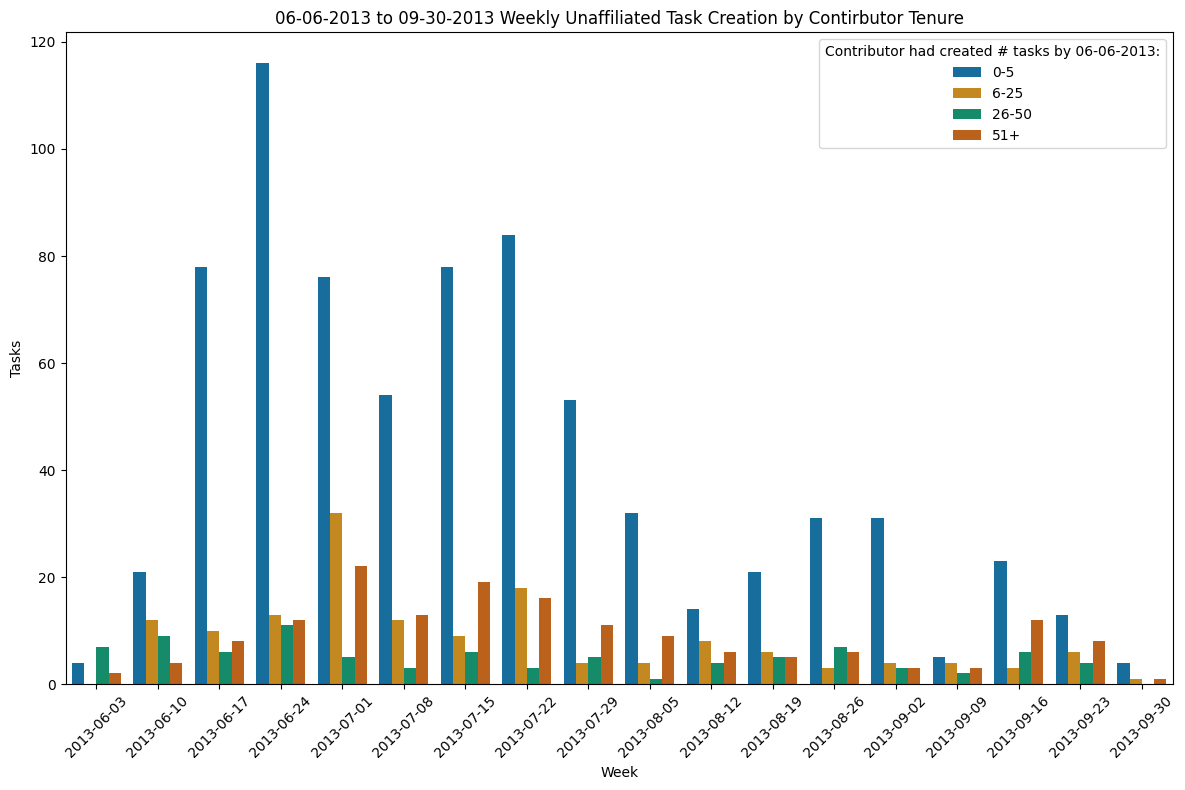

In [27]:
task_phab_df = phab_df[phab_df['comment_type'] == "task_description"]
unaff_tasks_phab_df = task_phab_df[task_phab_df['meta.affil'] != True]
# Rank speaker's task values within each group
unaff_tasks_phab_df['speakers_task'] = unaff_tasks_phab_df.groupby('speaker')['timestamp'].rank(method='first').astype(int)

# Filter dates 06-06-2013 to 09-30-2013
unaff_tasks_phab_df = unaff_tasks_phab_df[(unaff_tasks_phab_df['date_created'] < 1380585599) & (unaff_tasks_phab_df['date_created'] > 1370476800)]
# Bin the speakers based on the number of tasks they created
bins = [0, 6, 26, 51, float('inf')]
labels = ['0-5', '6-25', '26-50', '51+']
min_speakers_task = unaff_tasks_phab_df.groupby('speaker')['speakers_task'].min().reset_index()
min_speakers_task = min_speakers_task.rename(columns={'speakers_task': 'min_speakers_task'})
unaff_tasks_phab_df = unaff_tasks_phab_df.merge(min_speakers_task, on='speaker', how='left')
unaff_tasks_phab_df['task_bins'] = pd.cut(unaff_tasks_phab_df['min_speakers_task'], bins=bins, labels=labels, right=False)

# Calculate the weekly breakdown of binned speakers_task values
unaff_tasks_phab_df['week'] = unaff_tasks_phab_df['timestamp'].dt.to_period('W').dt.start_time
weekly_breakdown = unaff_tasks_phab_df.groupby(['week', 'task_bins']).size().unstack(fill_value=0)

speaker_breakdown = unaff_tasks_phab_df.groupby(['week', 'task_bins']).nunique()['speaker'].unstack(fill_value=0)

# Reshape the DataFrame for use with Seaborn
weekly_breakdown = weekly_breakdown.reset_index().melt(id_vars='week', value_vars=labels, var_name='task_bins', value_name='count')
speaker_breakdown = speaker_breakdown.reset_index().melt(id_vars='week', value_vars=labels, var_name='task_bins', value_name='speakers')

# Plot the stacked bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=weekly_breakdown, x='week', y='count', hue='task_bins', palette='colorblind')
#sns.barplot(data=speaker_breakdown, x='week', y='speakers', hue='task_bins', palette='colorblind')
plt.title("06-06-2013 to 09-30-2013 Weekly Unaffiliated Task Creation by Contirbutor Tenure")
plt.xlabel('Week')
plt.ylabel('Tasks')
plt.legend(title="Contributor had created # tasks by 06-06-2013:")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()

plt.savefig('042125_weekly_tasks_by_history.png')

/tmp/ipykernel_5608/1399682200.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comment_counts = affective_comment_phab_df.groupby('date_group').size()
/tmp/ipykernel_5608/1399682200.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speaker_counts = affective_comment_phab_df.groupby('date_group')['speaker'].nunique()
/tmp/ipykernel_5608/1399682200.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comment_counts

Number of comments for each date group:
date_group
Before announcement                              1858
After announcement, before opt-out deployment    1403
After opt-out deployment                         4726
dtype: int64

Number of speakers for each date group:
date_group
Before announcement                              104
After announcement, before opt-out deployment     92
After opt-out deployment                         184
Name: speaker, dtype: int64


/tmp/ipykernel_5608/1399682200.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  speaker_counts_engaged = affective_comment_phab_df.groupby(['date_group', 'est_commenter', 'meta.affil'])['speaker'].nunique()



Number of comments for each date group and engaged commenter subgroup:
date_group                                     est_commenter  meta.affil
Before announcement                            False          False          613
                                                              True            84
                                               True           False          836
                                                              True           325
After announcement, before opt-out deployment  False          False          589
                                                              True           104
                                               True           False          492
                                                              True           218
After opt-out deployment                       False          False         2512
                                                              True           510
                                             

'\nplot1 = sns.lmplot(data=comment_phab_df, x="date_created", y="dominant_wc", hue="date_group", col="meta.affil", row=\'new_commenter\', scatter=False, legend=False, palette=palette)\nplot1.set_axis_labels("Timestamp", "Count of Dominance Polarized Words")\nplot1.set_titles(row_template="Author\'s 100+ Comment: {row_name}",col_template="WMF Affiliation: {col_name}")\nplot1.fig.subplots_adjust(top=0.9)  # Adjust subplots to make room for the title\nplot1.add_legend(title="Comment publication timestamp:")\nfig1 = plot1.fig\n# Plot for arousal_wc\nplot2 = sns.lmplot(data=comment_phab_df, x="date_created", y="arousal_wc", hue="date_group", col="meta.affil", row=\'engaged_commenter\', scatter=False, legend=False, palette=palette)\nplot2.set_axis_labels("Timestamp", "Count of Arousal Polarized Words")\nplot2.set_titles(row_template="Author\'s 100+ Comment: {row_name}",col_template="WMF Affiliation: {col_name}")\nplot2.add_legend(title="Comment publication timestamp:")\n#plot2.add_legend(tit

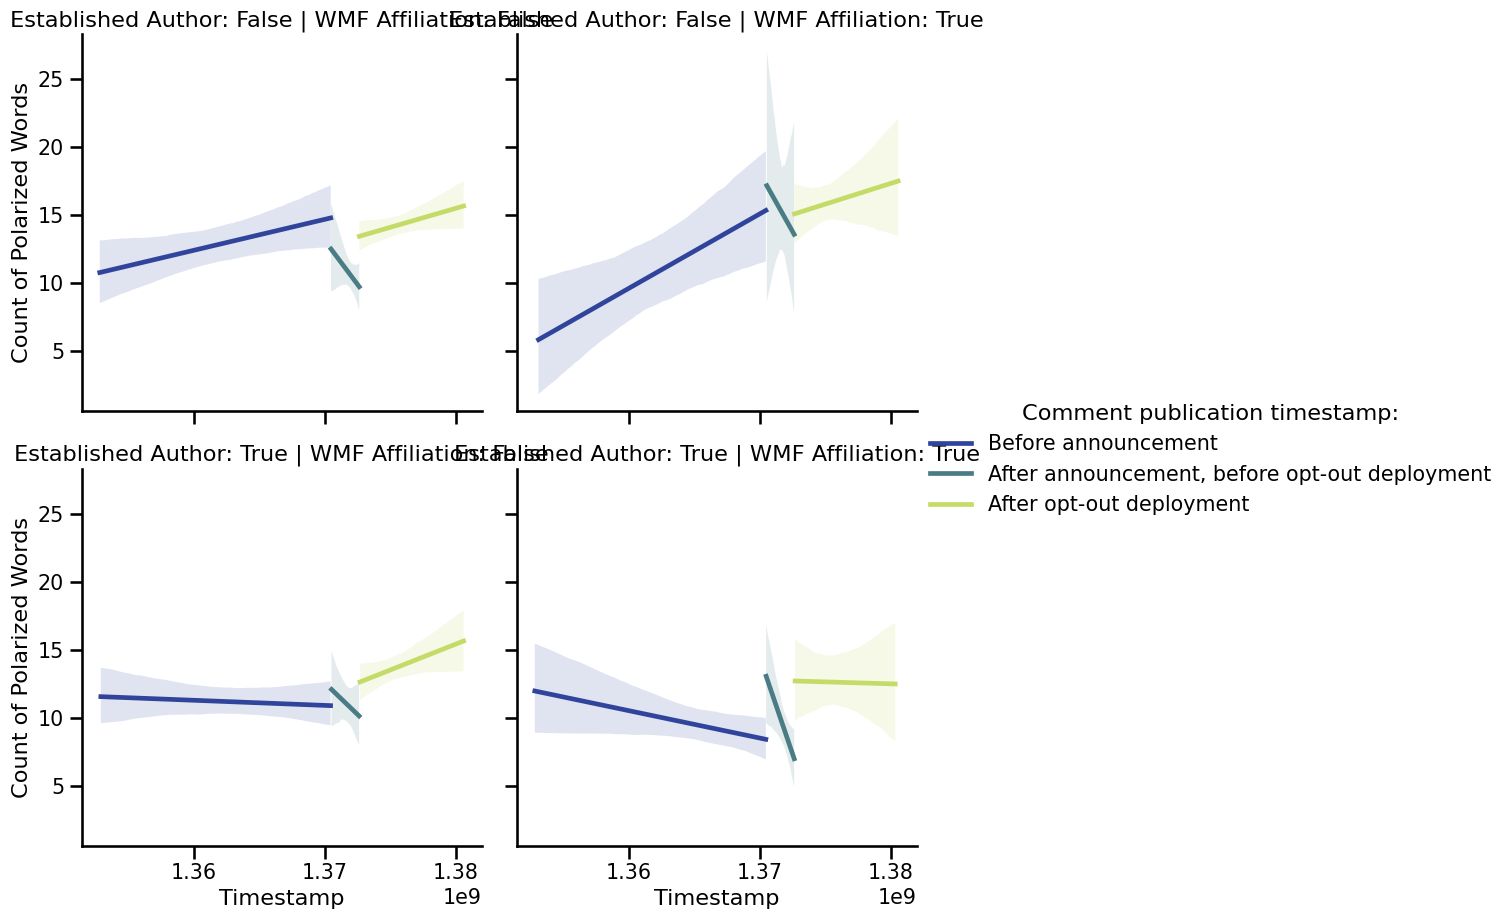

In [53]:
bins = [
    pd.Timestamp('1900-01-01 00:00:01+00:00'),
    pd.Timestamp('2013-06-06 00:00:01+00:00'),
    pd.Timestamp('2013-07-01 00:00:01+00:00'),
    pd.Timestamp('2100-01-01 00:00:01+00:00')
]
labels = ['Before announcement', 'After announcement, before opt-out deployment', 'After opt-out deployment']

#creating variables of interest
affective_comment_phab_df = comment_phab_df
affective_comment_phab_df['date_group'] = pd.cut(affective_comment_phab_df['timestamp'], bins=bins, labels=labels, right=False)
affective_comment_phab_df['speakers_comment'] = affective_comment_phab_df.groupby('speaker')['timestamp'].rank(method='first').astype(int)
#all comments prior to june 1 2013
subset_comment_phab_df = affective_comment_phab_df[affective_comment_phab_df['date_created'] <= 1370044800]
#getting counts 
comment_counts = subset_comment_phab_df.groupby('speaker')['speakers_comment'].max().reset_index()
comment_counts = comment_counts.rename(columns={'speakers_comment': 'pre_june_2013_comments'})
#merge back 
affective_comment_phab_df = affective_comment_phab_df.merge(comment_counts, on='speaker', how='left')
affective_comment_phab_df['pre_june_2013_comments'] = affective_comment_phab_df['pre_june_2013_comments'].fillna(0)

affective_comment_phab_df['new_commenter'] = affective_comment_phab_df['pre_june_2013_comments'] <= 10
affective_comment_phab_df['est_commenter'] = affective_comment_phab_df['pre_june_2013_comments'] > 50

palette = ['#31449c', '#4a7c85', '#c5db68']

comment_counts = affective_comment_phab_df.groupby('date_group').size()
speaker_counts = affective_comment_phab_df.groupby('date_group')['speaker'].nunique()

print("Number of comments for each date group:")
print(comment_counts)
print("\nNumber of speakers for each date group:")
print(speaker_counts)

comment_counts_engaged = affective_comment_phab_df.groupby(['date_group', 'est_commenter', 'meta.affil']).size()
speaker_counts_engaged = affective_comment_phab_df.groupby(['date_group', 'est_commenter', 'meta.affil'])['speaker'].nunique()

print("\nNumber of comments for each date group and engaged commenter subgroup:")
print(comment_counts_engaged)
print("\nNumber of speakers for each date group and engaged commenter subgroup:")
print(speaker_counts_engaged)

comment_counts_wmf = affective_comment_phab_df.groupby(['est_commenter', 'meta.affil']).size()
speaker_counts_wmf = affective_comment_phab_df.groupby(['est_commenter', 'meta.affil'])['speaker'].nunique()

print("\nNumber of comments for each engaged commenter subgroup, and WMF affiliation:")
print(comment_counts_wmf)
print("\nNumber of speakers for each engaged commenter subgroup, and WMF affiliation:")
print(speaker_counts_wmf)

#comment_phab_df['before_after'] = comment_phab_df['timestamp'] > pd.Timestamp('2013-07-01 00:00:01+00:00')
#fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
affective_comment_phab_df['polarized_wc'] = affective_comment_phab_df['dominant_wc'] + affective_comment_phab_df['valence_wc'] + affective_comment_phab_df['arousal_wc'] 
plot1 = sns.lmplot(data=affective_comment_phab_df, x="date_created", y="polarized_wc", hue="date_group", col="meta.affil", row='est_commenter', scatter=False, legend=False, palette=palette)
plot1.set_axis_labels("Timestamp", "Count of Polarized Words")
plot1.set_titles(row_template="Established Author: {row_name}", col_template="WMF Affiliation: {col_name}")
plot1.fig.subplots_adjust(top=0.9)  # Adjust subplots to make room for the title
plot1.add_legend(title="Comment publication timestamp:")
fig1 = plot1.fig
'''
plot1 = sns.lmplot(data=comment_phab_df, x="date_created", y="dominant_wc", hue="date_group", col="meta.affil", row='new_commenter', scatter=False, legend=False, palette=palette)
plot1.set_axis_labels("Timestamp", "Count of Dominance Polarized Words")
plot1.set_titles(row_template="Author's 100+ Comment: {row_name}",col_template="WMF Affiliation: {col_name}")
plot1.fig.subplots_adjust(top=0.9)  # Adjust subplots to make room for the title
plot1.add_legend(title="Comment publication timestamp:")
fig1 = plot1.fig
# Plot for arousal_wc
plot2 = sns.lmplot(data=comment_phab_df, x="date_created", y="arousal_wc", hue="date_group", col="meta.affil", row='engaged_commenter', scatter=False, legend=False, palette=palette)
plot2.set_axis_labels("Timestamp", "Count of Arousal Polarized Words")
plot2.set_titles(row_template="Author's 100+ Comment: {row_name}",col_template="WMF Affiliation: {col_name}")
plot2.add_legend(title="Comment publication timestamp:")
#plot2.add_legend(title="Before/After 07/01/2013 Wide Release")

plot3 = sns.lmplot(data=comment_phab_df, x="date_created", y="valence_wc", hue="date_group", col="meta.affil", row='engaged_commenter', scatter=False, legend=False, palette=palette)
plot3.set_axis_labels("Timestamp", "Count of Valence Polarized Words")
plot3.set_titles(row_template="Author's 100+ Comment: {row_name}",col_template="WMF Affiliation: {col_name}")
plot3.add_legend(title="Comment publication timestamp:")
'''
# Show plots
#fig1.savefig('031725_engaged_commenter_D_scoring_fig.png')
#plot2.fig.savefig('031725_engaged_commenter_A_scoring_fig.png')
#plot3.fig.savefig('031725_engaged_commenter_V_scoring_fig.png')
#plt.savefig('031625_engaged_commenter_VAD_scoring_fig.png')

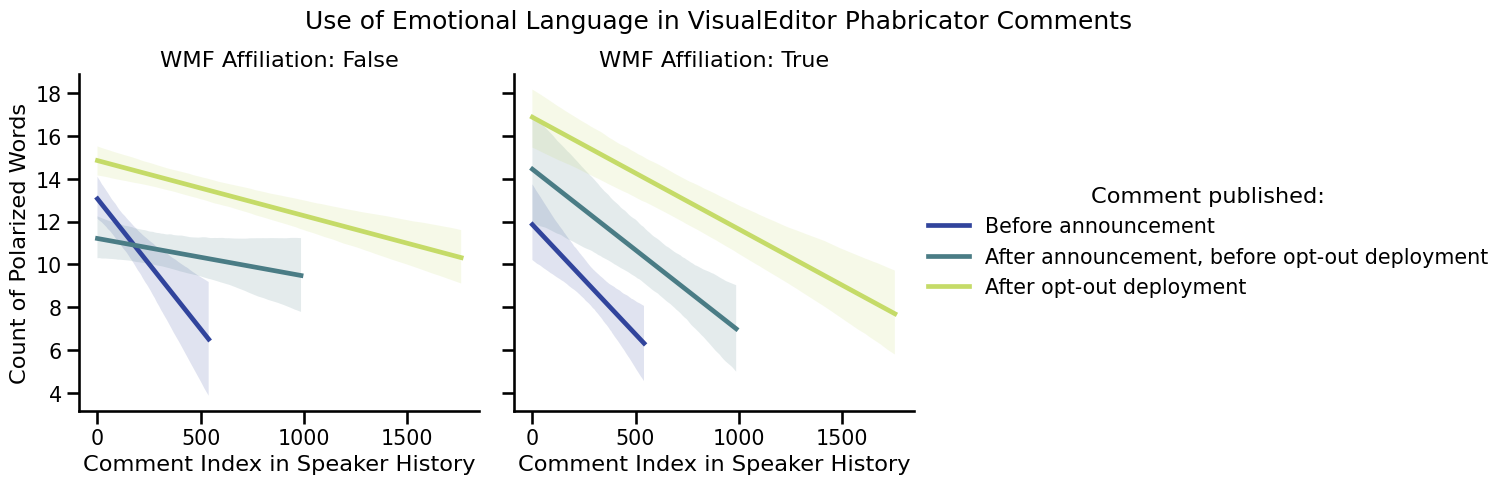

In [55]:
sns.set_context("talk", font_scale=0.9)
plot2 = sns.lmplot(data=affective_comment_phab_df, x="speakers_comment", y="polarized_wc", hue="date_group", col="meta.affil", scatter=False, legend=False, palette=palette)
plot2.set_axis_labels("Comment Index in Speaker History", "Count of Polarized Words")
plot2.set_titles(col_template="WMF Affiliation: {col_name}")
plot2.fig.suptitle("Use of Emotional Language in VisualEditor Phabricator Comments", fontsize=18)

plot2.fig.subplots_adjust(top=0.85)  # Adjust subplots to make room for the title

#plot2.legend.set_bbox_to_anchor([0.5, 1.05])  # Position legend at the top-center
#plot2.legend.set_loc("upper center")  # Center the legend horizontally
plot2.add_legend(title="Comment published:")

plot2.fig.savefig('c1-050125_affective_language_use-paper.png')

/tmp/ipykernel_43056/387535334.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_dependencies = dependency_relations_df[dependency_relations_df['token'].str.contains(pattern, regex=True)]
/tmp/ipykernel_43056/387535334.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  resolved_filtered_dependencies = resolved_dependency_relations_df[resolved_dependency_relations_df['token'].str.contains(pattern, regex=True)]
/tmp/ipykernel_43056/387535334.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dependencies['timestamp'] = pd.to_datetime(filtered_dependen

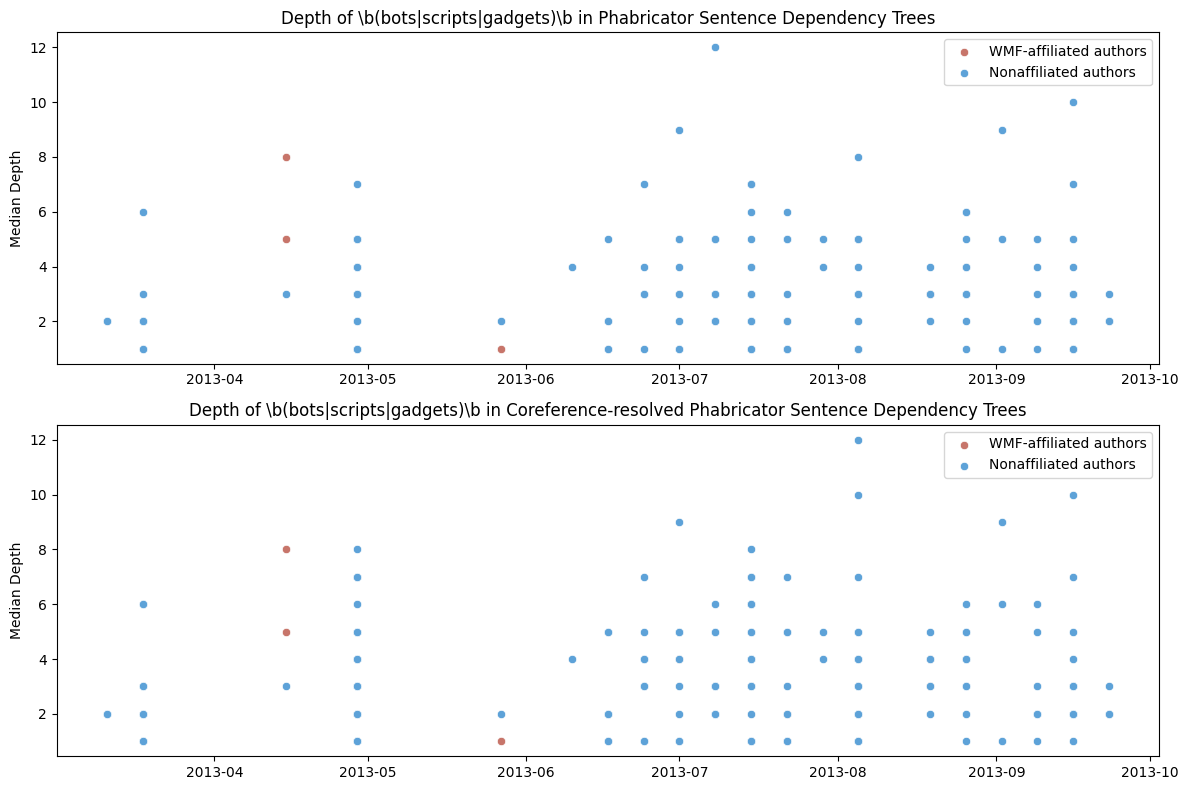

In [21]:
#pattern = r'\b(ve|VE|visualeditor|VisualEditor)\b'
#pattern = r'\b(WMF|Foundation)\b'
#pattern = r'\b(contributor|community|volunteer)\b'
pattern = r'\b(bots|scripts|gadgets)\b'
filtered_dependencies = dependency_relations_df[dependency_relations_df['token'].str.contains(pattern, regex=True)]
resolved_filtered_dependencies = resolved_dependency_relations_df[resolved_dependency_relations_df['token'].str.contains(pattern, regex=True)]

plt.figure(figsize=(12, 8))
gs = GridSpec(2, 1, height_ratios=[6, 6])

# Main plot: Token depth by timestamp
'''
ax0 = plt.subplot(gs[0])
sns.scatterplot(data=filtered_dependencies, x='timestamp', y='dependency', hue='wmfAffil', style='dependency', markers=True, s=100, ax=ax0)
ax0.set_title('VE Depth by Timestamp w/o URLS')
ax0.set_xlabel('')
ax0.set_ylabel('Dependency Type')
ax0.legend().set_visible(False)
'''
# Calculate the median depth over time
filtered_dependencies['timestamp'] = pd.to_datetime(filtered_dependencies['timestamp'], utc=True)
filtered_dependencies['week'] = filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
median_depth = filtered_dependencies.groupby('week')['depth'].median().reset_index()

wmf_filtered_dependencies = filtered_dependencies[filtered_dependencies['wmfAffil'] == True]
#wmf_median_depth = wmf_filtered_dependencies.groupby('week')['depth'].median().reset_index()

other_filtered_dependencies = filtered_dependencies[filtered_dependencies['wmfAffil'] != True]
#other_median_depth = other_filtered_dependencies.groupby('week')['depth'].median().reset_index()

# Plot the median depth over time
ax0 = plt.subplot(gs[0])
#sns.lineplot(data=median_depth, x='week', y='depth', ax=ax0, color='black', label='Median Depth', marker='o')
sns.scatterplot(data=wmf_filtered_dependencies, x='week', y='depth', ax=ax0, color='#c7756a', label='WMF-affiliated authors', marker='o')
#sns.lineplot(data=wmf_median_depth, x='week', y='depth', ax=ax0, color='#c7756a', label='WMF-affiliated authors', marker='x')
sns.scatterplot(data=other_filtered_dependencies, x='week', y='depth', ax=ax0, color='#5da2d8', label='Nonaffiliated authors', marker='o')
#sns.lineplot(data=other_median_depth, x='week', y='depth', ax=ax0, color='#5da2d8', label='Nonaffiliated authors', marker='x')
ax0.set_title(f'Depth of {pattern} in Phabricator Sentence Dependency Trees')
ax0.set_ylabel('Median Depth')
ax0.set_xlabel('')

# Calculate the median depth over time
resolved_filtered_dependencies['timestamp'] = pd.to_datetime(resolved_filtered_dependencies['timestamp'], utc=True)
resolved_filtered_dependencies['week'] = resolved_filtered_dependencies['timestamp'].dt.to_period('W').dt.start_time
resolved_median_depth = resolved_filtered_dependencies.groupby('week')['depth'].median().reset_index()

resolved_wmf_filtered_dependencies = resolved_filtered_dependencies[resolved_filtered_dependencies['wmfAffil'] == True]
#resolved_wmf_median_depth = resolved_wmf_filtered_dependencies.groupby('week')['depth'].median().reset_index()

resolved_other_filtered_dependencies = resolved_filtered_dependencies[resolved_filtered_dependencies['wmfAffil'] != True]
#resolved_other_median_depth = resolved_other_filtered_dependencies.groupby('week')['depth'].median().reset_index()

# Plot the median depth over time
ax1 = plt.subplot(gs[1])
#sns.lineplot(data=resolved_median_depth, x='week', y='depth', ax=ax1, color='black', label='Median Depth', marker='o')
sns.scatterplot(data=resolved_wmf_filtered_dependencies, x='week', y='depth', ax=ax1, color='#c7756a', label='WMF-affiliated authors', marker='o')
#sns.lineplot(data=resolved_wmf_median_depth, x='week', y='depth', ax=ax1, color='#c7756a', label='WMF-affiliated authors', marker='x')
sns.scatterplot(data=resolved_other_filtered_dependencies, x='week', y='depth', ax=ax1, color='#5da2d8', label='Nonaffiliated authors', marker='o')
#sns.lineplot(data=resolved_other_median_depth, x='week', y='depth', ax=ax1, color='#5da2d8', label='Nonaffiliated authors', marker='x')
ax1.set_title(f'Depth of {pattern} in Coreference-resolved Phabricator Sentence Dependency Trees')
ax1.set_ylabel('Median Depth')
ax1.set_xlabel('')

plt.tight_layout()
